In [1]:
import pyximport
pyximport.install()

(None, <pyximport.pyximport.PyxImporter at 0x7ff19a7fa7b8>)

In [2]:
from opera_tools.opera_distance_metric import generate_k_nearest_graph, opera_distance_metric_py, generate_radius_graph

In [6]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="6"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from tqdm import tqdm
from sklearn.cluster import DBSCAN


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
df_train = load('data/opera_train.data')


## Prepare different graphs and save to the folder

In [5]:
def make_graph_df(brick_id):
    df_brick = df_train[df_train['brick_id'] == brick_id]
    
    edges_from, edge_to, dist = generate_k_nearest_graph(df_brick.values, 
                                                         5,# change
                                                         symmetric=True)   
    graph_df = pd.DataFrame()
    graph_df['from'] = edges_from
    graph_df['to'] = edge_to
    graph_df['dist'] = dist
    
    graph_df.to_csv('data/graph_dfs/top5/{}.csv'.format(brick_id))
    

In [43]:
from multiprocessing import Pool

p = Pool(16)

p.map(make_graph_df,  df_train['brick_id'].unique())


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [6]:
label = pd.read_csv('data/opera_train.solution', sep=' ', header=None)
label.columns = ['brick_id', 'shower_id']
del label['brick_id']# = label['brick_id'].astype('float')
df_train = pd.concat([df_train, label], axis=1)

In [78]:
df_train['a0'] = np.arctan2(df_train['SX'].values.copy(), df_train['SY'].values.copy())
df_train['sin_a0'] = np.sin(df_train['a0'].values)
df_train['cos_a0'] = np.cos(df_train['a0'].values) 
df_train['rt'] = np.sqrt(df_train['SX'].values.copy() ** 2 + df_train['SX'].values.copy() ** 2)

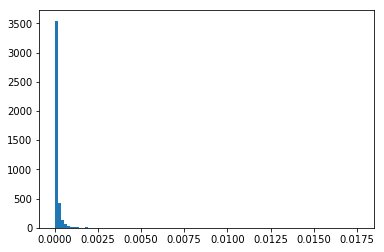

In [124]:
plt.hist(node_feat[node_feat.columns[-5]], bins=100)
plt.show()

## Calculate source graph-features

In [7]:
feat_train = []

for brick_id in tqdm(df_train['brick_id'].unique()[:]):
    df_brick = df_train[df_train['brick_id'] == brick_id]
    df_brick.index = range(len(df_brick))
    df_graph = pd.read_csv('data/graph_dfs/top5/{}.csv'.format(brick_id)) # repeat for all graphs
    
    node_feat = df_graph.groupby('from').agg({'dist' : ['sum', 'max', 'mean', 'std', 'median']})
    node_feat = pd.concat([df_brick, node_feat], axis=1)
#     info = node_feat[['brick_id', 'shower_id']]

    
#     node_feat = node_feat.drop(['brick_id', 'shower_id'], axis=1)
#     node_feat = sc.fit_transform(node_feat)
    feat_train.append(node_feat)

feat_train = pd.concat(feat_train, axis=0)
feat_train.index = range(len(feat_train))

100%|██████████| 230/230 [00:20<00:00, 12.81it/s]


In [35]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

info = feat_train[['brick_id', 'shower_id']]

feat_train = feat_train.drop(['brick_id', 'shower_id'], axis=1)
feat_train = pd.DataFrame(sc.fit_transform(feat_train))

feat_train = pd.concat([info, feat_train], axis=1)

## Generator

In [9]:
def pair_generator(feat, batch_size=1000):
    while True:
        brick_id = np.random.choice(feat['brick_id'].unique())
        break_df = feat[feat['brick_id'] == brick_id]

        first = break_df.sample(batch_size)
        second = break_df.sample(batch_size)
        target = first['shower_id'].values == second['shower_id'].values

        first = first.drop(['brick_id', 'shower_id'], axis=1)
        second = second.drop(['brick_id', 'shower_id'], axis=1)
        first.index = range(len(first))
        second.index = range(len(second))

        yield [first.values, second.values], target
        #curr = pd.concat([first, second], axis=1)


In [12]:
for x_batch, y_batch in pair_generator(feat_train[feat_train['brick_id'] < 300]):
    break

In [10]:
from keras.layers import GlobalAveragePooling2D, Bidirectional, LSTM, TimeDistributed, Dense,\
Concatenate, Dropout, Input, Conv3D, MaxPooling3D, GlobalAveragePooling3D, Reshape, GlobalAveragePooling1D,\
Lambda
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.utils import multi_gpu_model
import keras.backend as K

Using TensorFlow backend.


In [11]:
inp = Input(shape=(10,))
x = Dense(128)(inp)
feature_model = Model(input=inp, output=x)

    
feat_a_inp = Input(shape=feature_model.output_shape[1:])
feat_b_inp = Input(shape=feature_model.output_shape[1:])


x1 = Lambda(lambda x: x[0] * x[1])([feat_a_inp, feat_b_inp])
x2 = Lambda(lambda x: x[0] + x[1])([feat_a_inp, feat_b_inp])
x3 = Lambda(lambda x: K.abs(x[0] - x[1]))([feat_a_inp, feat_b_inp])
x4 = Lambda(lambda x: K.square(x))(x3)
x = Concatenate()([x1, x2, x3, x4])
pred = Dense(1, use_bias=True, activation='sigmoid', name='weighted-average')(x)

head_model = Model([feat_a_inp, feat_b_inp], pred, name='head')


inp_a = Input(shape=(10,))
inp_b = Input(shape=(10,))

feat_a = feature_model(inp_a)
feat_b = feature_model(inp_b)

pred = head_model([feat_a, feat_b])
model = Model([inp_a, inp_b], pred)

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          1408        input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
head (Model)                    (None, 1)            513         model_1[1][0]                    
          

In [ ]:
import keras
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)



model.compile(loss='binary_crossentropy',
        optimizer=adam,
        metrics=['acc'])

In [ ]:
model.fit_generator(generator=pair_generator(feat_train[feat_train['brick_id'] <= 300]),
                    steps_per_epoch=1000,
                    epochs=40,
                    verbose=1,
                    #callbacks=[MultiGPUCbk(model_s, '../../hdd/weights/pass_conv3d_lstm_%d.h5')],
                    validation_data=pair_generator(feat_train[feat_train['brick_id'] > 300]),
                    validation_steps=1000,
                    class_weight=None,
                    max_queue_size=10,
                    workers=16,
                    use_multiprocessing=True,
                    shuffle=True,
                    initial_epoch=0)

Instructions for updating:
Use tf.cast instead.
Epoch 1/40


/usr/local/lib/python3.5/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 13s 13ms/step - loss: 0.3024 - acc: 0.9012 - val_loss: 0.2225 - val_acc: 0.9218
Epoch 2/40
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1814 - acc: 0.9321 - val_loss: 0.1719 - val_acc: 0.9235
Epoch 3/40
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1462 - acc: 0.9358 - val_loss: 0.1360 - val_acc: 0.9349
Epoch 4/40
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1165 - acc: 0.9464 - val_loss: 0.1318 - val_acc: 0.9321
Epoch 5/40
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1086 - acc: 0.9479 - val_loss: 0.1065 - val_acc: 0.9504
Epoch 6/40
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0999 - acc: 0.9545 - val_loss: 0.1021 - val_acc: 0.9545
Epoch 7/40
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0931 - acc: 0.9616 - val_loss: 0.0982 - val_acc: 0.9607
Epoch 8/40
1000/1000 [==============================] - 8s 8ms/step -

In [ ]:
model.save_weights('tmp.h5')

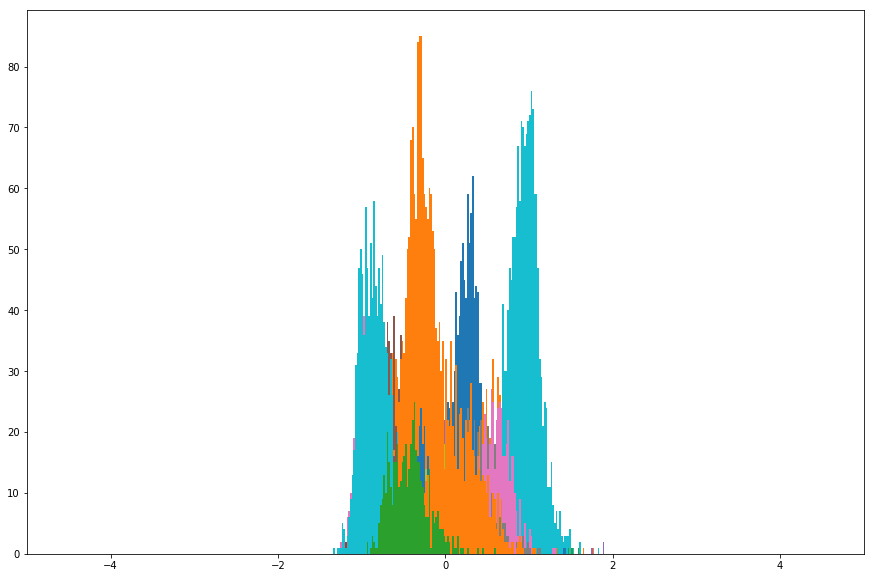

In [43]:
df_brick = df_train[df_train['brick_id'] == 2]

plt.figure(figsize=(15,10))
plt.xlim((-5, 5))

for shower_id in df_brick['shower_id'].unique()[:]:
    plt.hist(df_brick[df_brick['shower_id'] == shower_id]['nn_pca_feat'].values, range=(-2,2), bins=200)
    
plt.show()


In [ ]:
faeture_model = model.get_layer('model_1')
preds = faeture_model.predict(feat_train.drop(['brick_id', 'shower_id'], axis=1).values)

In [21]:
from sklearn.decomposition import PCA
pca = PCA(1)
nn_pca_feat = pca.fit_transform(preds)

In [27]:
df_train['nn_pca_feat'] = nn_pca_feat

In [28]:
preds.shape

(3000038, 128)

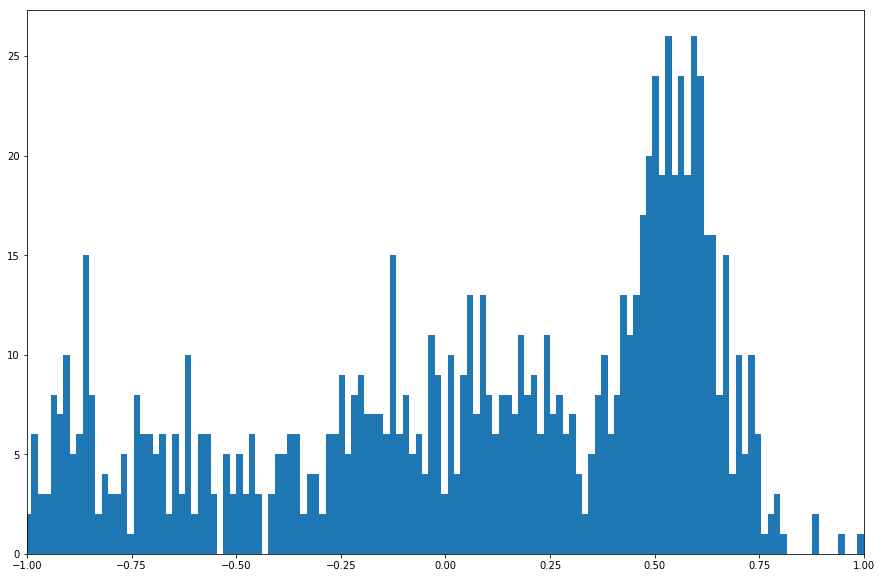

In [41]:
plt.figure(figsize=(15,10))
plt.xlim((-1, 1))

plt.hist(nn_pca_feat[10000:11000, 0], bins=200)
plt.show()

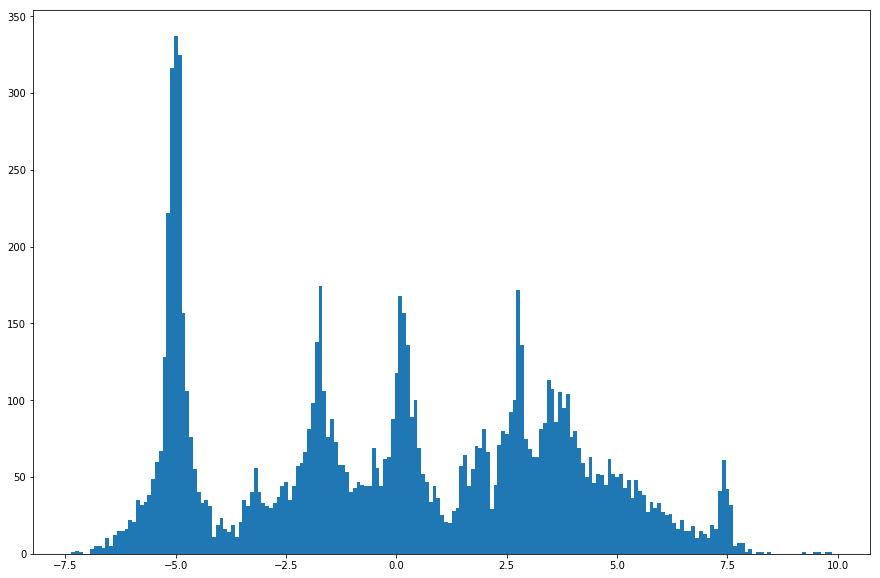

In [76]:
plt.figure(figsize=(15,10))
plt.hist(nn_pca_feat[:50000, 0], bins=200)
plt.show()

In [34]:
from sklearn.cluster import DBSCAN


predicted_labels = []

for brick_id in tqdm(feat_train['brick_id'].unique()[:]):
    dbscan = DBSCAN()
    brick_feat = feat_train[feat_train['brick_id'] == brick_id][['nn_pca_feat']] #*\
    #np.array([10,10,1,1])
    pred = dbscan.fit_predict(brick_feat.values)
    predicted_labels.append(pred)
        

preds = np.vstack([df_train.brick_id.values, np.concatenate(predicted_labels)]).T

100%|██████████| 230/230 [03:34<00:00,  1.07it/s]


In [24]:
feat_train['nn_pca_feat'] = nn_pca_feat

In [24]:
brick_feat = feat_train[feat_train['brick_id'] == 0][[0,1,2, 'nn_pca_feat']]

In [ ]:
scorer(labels_true=df_train[['brick_id', 'shower_id']].values, labels_pred=preds)

In [ ]:
0.6044310031029455